# <center>The simplex algorithm</center>
### <center>Alfred Galichon (NYU & Sciences Po)</center>
## <center>'math+econ+code' masterclass series</center>
#### <center>With python code examples</center>
© 2018–2023 by Alfred Galichon with contributions by Antoine Jacquet. Past and present support from NSF grant DMS-1716489, ERC grant CoG-866274 are acknowledged, as well as inputs from contributors listed [here](http://www.math-econ-code.org/team).

**If you reuse material from this masterclass, please cite as:**<br>
Alfred Galichon, 'math+econ+code' masterclass series. https://www.math-econ-code.org/

## Linear programming: the simplex algorithm

### Learning objectives

* The simplex algorithm

### References

* Vanderbei (1996). *Linear programming.* Springer

### Principle

The simplex algorithm was developed by G. B. Dantzig in 1947 as a way to solve linear programming problems of the canonical form

\begin{align}
\max_{x\in\mathbb{R}_{+}^{n}}  & ~ c^{\top} x \\
\text{s.t.} & ~ Ax \leq b
\end{align}

where $c \in \mathbb{R}^{n}$, $b \in \mathbb{R}^{m}$, and $A$ is a $m\times n$ matrix.

The idea of the algorithm is to start from a simple feasible point called a *basic feasible solution*, and then to iteratively identify directions along which the objective function increases.

Let's begin by loading the usual packages.

In [1]:
#!pip install gurobipy
import pandas as pd
import numpy as np
import scipy.sparse as spr
import gurobipy as grb
import sympy
from sympy.solvers import solve
from sympy import *
import matplotlib.pyplot as plt

def round_expr(expr, num_digits):
    return expr.xreplace({n : round(n, num_digits) for n in expr.atoms(Number)})

## The simplex algorithm with an example

Consider the linear programming problem:

\begin{align*}
\max_{x_1, x_2 \geq 0}  & ~ x_1 + x_2 \\
\text{s.t.} & ~ 2 x_1 + x_2 \leq 2 \\
            & ~ x_1 + 2 x_2 \leq 2.
\end{align*}


Before even starting the algorithm, we first need to transform this linear program into one in *standard form*, that is, to replace inequality constraints with equality ones. To achieve this, we introduce slack variables $z_i$ to rewrite the problem as

\begin{align*}
\max_{x_1, x_2, z_1, z_2 \geq 0}  & ~ x_1 + x_2 \\
\text{s.t.} & ~ z_1 = 2 - 2 x_1 - x_2 \\
            & ~ z_2 = 2 - x_1 - 2 x_2 .
\end{align*}

The variables $z_i$ are called *basic variables*, and the variables $x_j$ are called *nonbasic variables*.

Linear programming problems in this standard form can be summarized by a structure called a *tableau*. We begin by defining a `Tableau` class in Python to handle this type of data.  The expressions of the objective and of the basic variables as a function of the nonbasic ones are encoded into a *dictionary*:

In [2]:
class Tableau():
    def __init__(self, names_basic, names_nonbasic, A_i_j, b_i, c_j): # z = d - A @ x
        self.A_i_j,self.b_i,self.c_j = A_i_j,b_i,c_j
        self.nonbasic = list(symbols(names_nonbasic))
        self.base = { Symbol('obj') : c_j @ self.nonbasic }
        self.base.update( { list(symbols(names_basic))[i]: b_i[i]  - (A_i_j @ self.nonbasic)[i] for i in range(len(b_i))} )

    def variables(self):
        return( list(self.base.keys())[1:] + self.nonbasic)

    def display(self):
        print('-------------------------- \nObjective and constraints:')
        for i in self.base:
            print(i,' = ' ,round_expr(self.base[i],2))

We then define the tableau corresponding to our example.

In [3]:
example_tableau = Tableau(names_basic = ['z_1', 'z_2'],
                          names_nonbasic = ['x_1', 'x_2'],
                          A_i_j = np.array([[2, 1], [1, 2]]),
                          b_i = [2,2],
                          c_j = np.array([1,1]))

example_tableau.display()

-------------------------- 
Objective and constraints:
obj  =  x_1 + x_2
z_1  =  -2*x_1 - x_2 + 2
z_2  =  -x_1 - 2*x_2 + 2


### Description of the algorithm

Let's take a step-by-step approach to understand the simplex algorithm.
Along the way, we will also code these steps.

#### **Step 1: Initialize.**
Our first step is to establish a (feasible) starting point. There is an obvious one which consists in setting $x_1 = x_2 = 0$ and $z_1 = 2$, $z_2 = 2$. This starting point is called a *basic feasible solution* because it is zero outside of the basic variables. The value of the objective at this solution is $0$.

We create a method which computes the basic feasible solution associated with a tableau, as well as the value of the objective at this solution.

In [4]:
def Tableau_solution(self, verbose=0):
    solution = {}
    for var in self.base:
        solution[var] = float(self.base[var].subs([(variable,0) for variable in self.nonbasic]))
        if verbose > 0: print(str(var) + ' = ' + str(solution[var]))
    for var in self.nonbasic:
        solution[var] = 0.0
        if verbose > 1: print(str(var) + ' = ' + str(solution[var]))
    return solution

Tableau.solution = Tableau_solution

current_solution = example_tableau.solution(verbose=1)

obj = 0.0
z_1 = 2.0
z_2 = 2.0


We plot the feasible region and our initial solution using:


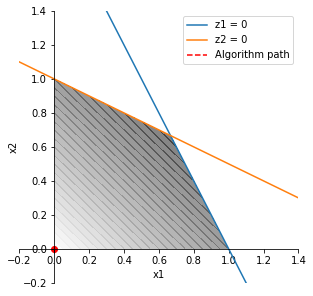

In [5]:
def Tableau_plot_path_so_far(self, the_path, legend=True):
    if self.A_i_j.shape[1] != 2:
        print('Can\'t plot the solution in 2D, the number of primal variables differs from two.')
        return()

    x1max = min(x for x in self.b_i / self.A_i_j[:,0] if x >= 0)
    x2max = min(x for x in self.b_i / self.A_i_j[:,1] if x >= 0)
    x1, x2 = np.meshgrid(np.linspace(-.2*x1max, 1.4*x1max, 400), np.linspace(-.2*x2max, 1.4*x2max, 400))
    feasible_region = (x1 >= 0) & (x2 >= 0)
    for i in range(len(self.b_i)) :
        feasible_region = feasible_region & (self.A_i_j[i,0] * x1 + self.A_i_j[i,1] * x2 <= self.b_i[i])
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.contourf(x1, x2, np.where(feasible_region, self.c_j[0]*x1+self.c_j[1]*x2, np.nan), 50, alpha = 0.5, cmap='gray_r', levels=30)
    for i in range(len(self.b_i)):
        if not self.A_i_j[i,1] == 0:
            ax.plot(x1[0, :], self.b_i[i]/self.A_i_j[i,1] - self.A_i_j[i,0]/self.A_i_j[i,1]*x1[0, :], label='z'+str(i+1)+' = 0')
        else:
            ax.axvline(self.b_i[i]/self.A_i_j[i,0], label='z'+str(i+1)+' = 0')
    ax.plot([a for (a,_) in the_path], [b for (_,b) in the_path], 'r--', label='Algorithm path')
    ax.scatter([a for (a,_) in the_path], [b for (_,b) in the_path], color='red')
    ax.set_xlim(-.2*x1max, 1.4*x1max), ax.set_ylim(-.2*x2max, 1.4*x2max)
    ax.set_xlabel('x1'), ax.set_ylabel('x2')
    ax.spines[ 'left' ].set_position('zero'), ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none'), ax.spines['top'].set_color('none')
    if legend: ax.legend(loc='upper right')
    plt.show()

Tableau.plot_path_so_far = Tableau_plot_path_so_far

the_path_so_far = [(current_solution[symbols('x_1')], current_solution[symbols('x_2')])]
example_tableau.plot_path_so_far(the_path_so_far)

#### **Step 2: Entering variable.**
We want to select a nonbasic variable in order to increase our objective. This variable is called *entering variable*. Any nonbasic variable whose coefficient in the objective is therefore a potential entering variable.

There are several ways to choose the entering variable. One possibility is to choose the variable that has the highest coefficient in the objective.

Another method is to follow *Bland's rule*, i.e. to select the first variable (in the alphabetical order) which has a positive coefficient in the objective. This method is the safest as it prevents the algorithm from cycling in some pathological cases, and therefore we will implement it here.

Recall that the objective in our example is $x_1 + x_2$, and therefore Bland's rule selects $x_1$ as the entering variable.

In [6]:
def Tableau_determine_entering(self):
    self.nonbasic.sort(key=str) # Bland's rule
    for entering_var in self.nonbasic:
        if diff(self.base[Symbol('obj')],entering_var)>0 :
            return entering_var
    return None # If no entering variable found, None returned

Tableau.determine_entering = Tableau_determine_entering

entering_var = example_tableau.determine_entering()
entering_var

x_1

#### **Step 3: Departing variable.**
When $x_1$ enters, we will increase $x_1$ until we hit one of the constraints $z_i \geq 0$. Recall:

\begin{align*}
z_1 &= 2 - 2 x_1 - x_2 \\
z_2 &= 2 - x_1 - 2 x_2.
\end{align*}

Note that we keep $x_2=0$ along the way. Here it is the constraint $z_1 \geq 0$ which will hit first (for $x_1 = 1$). Therefore we choose $z_1$ as our *departing variable*.

In general, if $j^\star$ is the entering variable, the formula for determining the departing variable is

$i^\star = \arg\min_{\, i} \left\{ \frac {b_i} {A_{i \, j^\star}} : A_{i \, j^\star} > 0  \right\}$.

We code this into:

In [7]:
def Tableau_determine_departing(self,entering_var):
  runmin = float('inf')
  departing_var = None
  for var in self.base.keys() - {Symbol('obj')}:
        the_expr_list = solve(self.base[var] - var,entering_var)
        if the_expr_list: # if one can invert the previous expression
            the_expr = the_expr_list[0] # express entering variable as a function of the other ones:
            val_entering_var = the_expr.subs([ (variable,0) for variable in [var]+self.nonbasic])
            if (val_entering_var >= 0) & (val_entering_var < runmin) :
              runmin,departing_var = val_entering_var, var
  return departing_var # if no variable is found, None returned

Tableau.determine_departing = Tableau_determine_departing

departing_var = example_tableau.determine_departing(entering_var)
departing_var

z_1

#### **Step 4: Updating.**
We reformulate our problem with our new basis $(x_1, z_2)$. We use the constraint associated with our departing variable $z_1$ as a pivot to eliminate the entering variable $x_1$ from the other equalities:

\begin{matrix}
&\tfrac{1}{2}z_1  &       &~+ x_1 &+~ \tfrac{1}{2} x_2 &= 1 \\
&-\tfrac{1}{2}z_1 &+~ z_2 &       &+~ \tfrac{3}{2} x_2 &= 1
\end{matrix}

and we rewrite the objective as a function of the new nonbasic variables:

\begin{align*}
x_1 + x_2
&= \left(1 - \tfrac{1}{2}z_1 - \tfrac{1}{2}x_2\right) + x_2 \\
&= 1 + \tfrac{1}{2}x_2 - \tfrac{1}{2}z_1.
\end{align*}

In general, once the entering variable $j^\star$ and the departing variable $i^\star$ have been determined, we need to update our set of nonbasic variables by removing $i^\star$ from it and adding $j^\star$. We also need to update our dictionary with the expression of our entering variable,

$x_{j^\star}
= \frac {b_{i^\star}} {A_{i^\star j^\star}}
- \sum_{j \neq j^\star} \frac {A_{i^\star j}} {A_{i^\star j^\star}} x_j
- \frac {z_{i^\star}} {A_{i^\star j^\star}}$

and substituting out this expression in

$z_i = b_i - \sum_j A_{ij} x_j, \quad i \neq i^\star$

yields the expression of the new basic variables as a function of the new nonbasic variables.

In [8]:
def Tableau_pivot(self,entering_var,departing_var, verbose = 0):
    expr_entering = solve(self.base[departing_var] - departing_var,entering_var)[0]
    for var in self.base:
        self.base[var] = self.base[var].subs([(entering_var, expr_entering)])
    self.base[entering_var] = expr_entering
    del self.base[departing_var]
    self.nonbasic.remove(entering_var)
    self.nonbasic.append(departing_var)
    if verbose > 0:
        print('Entering = ' + str( entering_var)+'; departing = '+ str( departing_var))
    if verbose > 1:
        print(str( entering_var)+' = '+str(round_expr(expr_entering,2)))
    return expr_entering

Tableau.pivot = Tableau_pivot

expr_entering_var = example_tableau.pivot(entering_var,departing_var,verbose = 2)

example_tableau.display()

Entering = x_1; departing = z_1
x_1 = -0.5*x_2 - 0.5*z_1 + 1
-------------------------- 
Objective and constraints:
obj  =  0.5*x_2 - 0.5*z_1 + 1
z_2  =  -1.5*x_2 + 0.5*z_1 + 1
x_1  =  -0.5*x_2 - 0.5*z_1 + 1


This completes one iteration of the algorithm.

### Iterating

The transformed program is now:

\begin{align*}
\max_{x_1, x_2, z_1, z_2 \geq 0}  & ~ 1 + \tfrac{1}{2}x_2 - \tfrac{1}{2}z_1 \\
\text{s.t.} & ~ x_1 = 1 - \tfrac{1}{2} x_2 - \tfrac{1}{2} z_1 \\
            & ~ z_2 = 1 - \tfrac{3}{2} x_2 + \tfrac{1}{2}z_1 .
\end{align*}

Our new basic feasible solution is $x_2 = z_1 = 0$ (nonbasic variables) and $x_1 = 1$, $z_2 = 1$ (basic variables). The value of the objective is $1$.



Let's look at the path that the algorithm took using the graph.

obj = 1.0
z_2 = 1.0
x_1 = 1.0
x_2 = 0.0
z_1 = 0.0


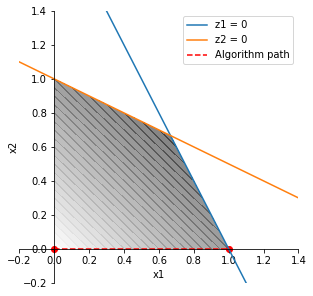

In [9]:
current_solution = example_tableau.solution(verbose=2)
the_path_so_far.append((current_solution[symbols('x_1')], current_solution[symbols('x_2')]))
example_tableau.plot_path_so_far(the_path_so_far)

We can now repeat the process on the new program. Since the coefficient of $x_2$ in our new objective is positive, we now choose $x_2$ as an entering variable. In that case, the constraint associated with the basic variable $z_2$ will hit first, so $z_2$ will be our departing variable.

The pivot operation yields

\begin{matrix}
&\tfrac{2}{3}z_1  &-~ \tfrac{1}{3} z_2       &~+ x_1 & &= \tfrac{2}{3} \\
&-\tfrac{1}{3}z_1 &+~ \tfrac{2}{3} z_2 &       &+~ x_2 &= \tfrac{2}{3}
\end{matrix}

and the new objective is

\begin{align*}
1 + \tfrac{1}{2}x_2 - \tfrac{1}{2}z_1
&= 1 + \tfrac{1}{2}\left(\tfrac{2}{3} + \tfrac{1}{3}z_1 - \tfrac{2}{3}z_2\right) - \tfrac{1}{2}z_1 \\
&= \tfrac{4}{3} - \tfrac{1}{3}z_1 - \tfrac{1}{3}z_2.
\end{align*}

We encode this second iteration as:

Entering = x_2; departing = z_2
x_2 = 0.33*z_1 - 0.67*z_2 + 0.67
obj = 1.3333333333333333
x_1 = 0.6666666666666666
x_2 = 0.6666666666666666
z_1 = 0.0
z_2 = 0.0


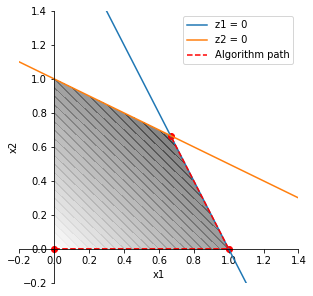

In [10]:
entering_var = example_tableau.determine_entering()
departing_var = example_tableau.determine_departing(entering_var)
example_tableau.pivot(entering_var, departing_var, verbose=2)

current_solution = example_tableau.solution(verbose=2)
the_path_so_far.append((current_solution[symbols('x_1')], current_solution[symbols('x_2')]))
example_tableau.plot_path_so_far(the_path_so_far)

Our new basic feasible solution is $z_1 = z_2 = 0$ (nonbasic variables) and $x_1 = \tfrac{2}{3}$, $x_2 = \tfrac{2}{3}$ (basic variables). But because the coefficients of the nonbasic variables in the objective are negative, we cannot increase it anymore: the algorithm stops.

We verify this with our code, as there is no entering variable anymore.

In [11]:
print(example_tableau.determine_entering())

None


The value of the initial problem is thus $\tfrac{4}{3}$, and the optimal solution is

\begin{equation}
  x_1^* = x_2^* = \tfrac{2}{3}.
\end{equation}

### Geometric interpretation

The simplex algorithm has a simple geometric interpretation.

The feasible set of the linear programming problem, delimited by its constraints, forms a polygon in $\mathbb R^2$ (a polyhedron in $\mathbb R^3$, etc.).

We start from one of the corners of this polygon. At each iteration of the algorithm, we move along the edge of the polygon to a neighboring corner, always moving in the direction that most increases the value of the objective function. When it reaches the corner with the highest possible value of the objective function, the algorithm stops, and we have our solution.

The simplex algorithm must stop eventually since there are a limited number of corners. Furthermore, it can be shown that if a corner isn't a maximum, then there must be an adjoining edge leading to a higher value of the objective function. This guarantees that the end point of the algorithm is indeed an optimal solution.

## Second example

Consider a slightly more complex example:

\begin{align*}
\max_{x_1, x_2 \geq 0}  & ~ 3 x_1 + 2 x_2 \\
\text{s.t.} & ~ \cos\left(\tfrac{k}{K}\tfrac{\pi}{2}\right) x_1 + \sin\left(\tfrac{k}{K}\tfrac{\pi}{2}\right) x_2 \leq 1, \quad k = 0, \dots, K.
\end{align*}

The constraints actually correspond to $K+1$ tangents to the circle of equation $x_1^2 + x_2^2 = 1$. Therefore, it is as if we were approximating the nonlinear constraint $x_1^2 + x_2^2 \leq 1$.

Entering = x_1; departing = z_0
Entering = x_2; departing = z_1
Entering = z_0; departing = z_2
Entering = z_1; departing = z_3
Entering = z_2; departing = z_4
Optimal solution found.
obj = 3.614058558900192
z_5 = 0.02462331880972555
z_6 = 0.07326364859996945
z_7 = 0.14472330302329706
z_8 = 0.23724270822681015
z_9 = 0.3485437294000968
z_10 = 0.47588576601495897
x_1 = 0.8552766969767034
x_2 = 0.5241142339850411
z_0 = 0.14472330302329667
z_1 = 0.07326364859996902
z_2 = 0.0246233188097251
z_3 = 0.0
z_4 = 0.0

Value = 3.61405855890019


C:\Users\alfre\AppData\Local\Temp\ipykernel_18356\3480862293.py:6: RuntimeWarning: divide by zero encountered in true_divide
  x1max = min(x for x in self.b_i / self.A_i_j[:,0] if x >= 0)
C:\Users\alfre\AppData\Local\Temp\ipykernel_18356\3480862293.py:7: RuntimeWarning: divide by zero encountered in true_divide
  x2max = min(x for x in self.b_i / self.A_i_j[:,1] if x >= 0)


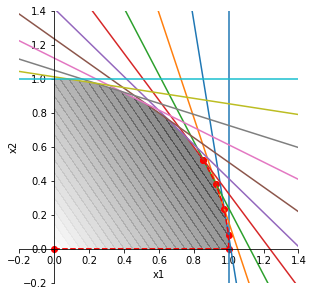

In [12]:
K = 10

example_tableau2 = Tableau(names_basic = ['z_'+str(k) for k in range(0,K+1)],
                           names_nonbasic = ['x_1', 'x_2'],
                           A_i_j = np.array([(float(cos(k/K*pi/2)), float(sin(k/K*pi/2))) for k in range(0, K+1)]),
                           b_i = np.ones(K+1),
                           c_j = np.array([3,2]))

def simplex_loop(self):
    entering_var = self.determine_entering()
    if entering_var is None:
        print('Optimal solution found.\n=======================')
        self.solution(verbose=2)
    else:
        departing_var = self.determine_departing(entering_var)
        if departing_var is None:
            print('Unbounded solution.')
        else:
            expr_entering_var = self.pivot(entering_var,departing_var, verbose=1)
            return False # not finished
    return True # finished

finished = False
the_path_so_far = [(example_tableau2.solution()[symbols('x_1')], example_tableau2.solution()[symbols('x_2')])]
while not finished:
  finished = simplex_loop(example_tableau2)
  the_path_so_far.append((example_tableau2.solution()[symbols('x_1')], example_tableau2.solution()[symbols('x_2')]))

print('\nValue = '+str(example_tableau2.base[Symbol('obj')].subs([ (variable,0) for variable in example_tableau2.nonbasic])))

example_tableau2.plot_path_so_far(the_path_so_far, legend=False)

Our algorithm still works! However you can check that it becomes quite slow for higher values of $K$.


## Application to the diet problem

Recall the diet problem:

* Assume there are nutrients $i \in \{1,\dots,I\}$ (calories, protein, calcium, iron, etc.) that matter for a person's health, in such way that the minimum daily intake of nutrient $i$ should be $d_{i}$.

* Nutrients do not come as standalone elements, but are combined into various foods. One dollar worth of food $j \in \{1,\dots,J\}$ yields a quantity $N_{ij}$ of nutrient $i \in \{1,\dots,I\}$.

The problem is to find the diet that achieves the minimal intake of each nutrient for the cheapest price. If $q\in\mathbb{R}^{J}$ is a vector such that $q_{j}\geq0$ is the quantity of food $j$ purchased, the quantity of nutrient $i$ ingested is $\sum_{j=1}^{J}N_{ij}q_{j}$, and the cost of the diet is $\sum_{j=1}^{J}q_{j}$. Letting $c_j = 1$ for all $j \in \{1,\dots,n\}$, the optimal diet is therefore given by

\begin{align*}
\min_{q\geq 0} & ~ c^{\top}q \\
\text{s.t.} & ~ Nq \geq d
\end{align*}

which has dual

\begin{align*}
\max_{\pi\geq0} & ~ d^{\top}\pi \\
\text{s.t.} & ~ N^{\top}\pi \leq c.
\end{align*}

We load the data using:

In [13]:
thepath = 'https://raw.githubusercontent.com/math-econ-code/mec_optim_2021-01/master/data_mec_optim/lp_stigler-diet/'
filename = 'StiglerData1939.txt'
thedata = pd.read_csv(thepath + filename, sep='\t')
thedata = thedata.dropna(how = 'all')
commodities = (thedata['Commodity'].values)[:-1]
allowance = thedata.iloc[-1, 4:].fillna(0).transpose()
N_i_j = thedata.iloc[:-1, 4:].fillna(0).transpose().values
N_i_j = N_i_j[:5,:7]
nbi, nbj = N_i_j.shape
c_j = np.ones(nbj)
d_i = np.array(allowance)[:nbi]

We shall introduce slack variables $s_j \geq 0$ and rewrite the dual problem in the standard form as:

\begin{align*}
\max_{s_j \geq 0, \pi_i \geq 0} & ~ \sum_{i} d_{i} \pi_i \\
\text{s.t.} & ~ s_j  + \sum_{i} N_{ij}\pi_i= c_j .
\end{align*}

We start from the *basic feasible solution*, $\pi_i = 0$ and $s_j = c_j$. The $J$ variables $s_1,\dots,s_J$ are the basic variables. The $I$ nonbasic variables, $\pi_1,\dots,\pi_I$, are set to zero.
One can express the basic variables as a function of the nonbasic variables as follows:

$s_j  = c_j - \sum_{i} N_{ij}\pi_i.$

The dual objective is also expressed as a function of the nonbasic variables:

$\text{obj}_D = \sum_{i} d_{i}\pi_i.$

These equalities constitute our *primal dictionary*.


We code this up as a tableau. First, we define the basic dual variables (the $s_j$), and the nonbasic dual variables (the $\pi_i$) .

In [14]:
dual_tableau = Tableau(['s_' + str(j) for j in range(nbj)],
                      ['pi_' + str(i) for i in range(nbi)],
                      N_i_j.T, c_j , d_i)
dual_tableau.variables()

[s_0, s_1, s_2, s_3, s_4, s_5, s_6, pi_0, pi_1, pi_2, pi_3, pi_4]

Something similar takes place for the primal problem. We introduce $t_i$ the slack variable associated with the constraint $\sum_{j} N_{ij}q_j \geq d_i$, and we obtain the following *primal dictionary*:

$t_i  = -d_i + \sum_{j} N_{ij}q_j.$

The primal objective is also expressed as a function of the nonbasic variables:

$\text{obj}_P = \sum_{j} c_{j}q_j.$

In [15]:
primal_tableau = Tableau(['t_' + str(i) for i in range(nbi)],
                      ['q_' + str(j) for j in range(nbj)],
                      N_i_j, d_i , c_j)
primal_tableau.variables()

[t_0, t_1, t_2, t_3, t_4, q_0, q_1, q_2, q_3, q_4, q_5, q_6]

We see that there is a natural correspondence between $\pi_i$ and $t_i$ on the one hand, and $s_j$ and $q_j$ on the other, which we encode into:

In [16]:
primals = {dual:Symbol(str(dual).replace('pi','t').replace('s','q')) for dual in dual_tableau.variables()}
primals[Symbol('pi_0')]

t_0

We also see that the nonbasic dual variables correspond to basic primal variables, and basic dual variables to nonbasic primal ones. The basis will change but we shall maintain that property, called *complementary slackness*, throughout.

We now look for our entering variable.

In [17]:
entering_var = dual_tableau.determine_entering()
entering_var

pi_0

On this example, variable $\pi_0$ will enter.

Next, we determine our departing variable.

In [18]:
departing_var = dual_tableau.determine_departing(entering_var)
departing_var

s_0

After having determined our entering and leaving variables, we update our dual dictionary with:

In [19]:
expr_entering_var = dual_tableau.pivot(entering_var,departing_var,verbose = 2)

Entering = pi_0; departing = s_0
pi_0 = -31.57*pi_1 - 0.04*pi_2 - 8.17*pi_3 - 0.02*s_0 + 0.02


We perform similar operations in the primal dictionary. In the dual dictionary, we have just determined that $\pi_{i^\star}$ entered the dual basis and $s_{j^\star}$ departed. As a result, in the primal dictionary, we will let $t_{i^\star}$ depart the primal basis and $y_{j^\star}$ enter.

This is coded into:

In [20]:
round_expr(primal_tableau.pivot(primals[departing_var],primals[entering_var]),2)


-0.26*q_1 - 0.26*q_2 - 0.26*q_3 - 0.81*q_4 - 0.64*q_5 - 0.47*q_6 - 0.02*t_0 + 0.07

We have completed one simplex step. Let's take a look at our dual dictionary after that step:

In [21]:
dual_tableau.display()

-------------------------- 
Objective and constraints:
obj  =  -24.7*pi_1 + 0.67*pi_2 - 12.5*pi_3 + 5.0*pi_4 - 0.07*s_0 + 0.07
s_1  =  -51.83*pi_1 - 0.18*pi_2 + 40.72*pi_3 + 0.26*s_0 + 0.74
s_2  =  -4.52*pi_1 - 13.87*pi_2 - 78.65*pi_3 + 0.26*s_0 + 0.74
s_3  =  107.85*pi_1 + 0.41*pi_2 + 37.09*pi_3 + 0.26*s_0 + 0.74
s_4  =  239.38*pi_1 - 0.09*pi_2 + 194.96*pi_3 - 30.9*pi_4 + 0.81*s_0 + 0.19
s_5  =  222.79*pi_1 + 0.48*pi_2 + 153.53*pi_3 + 0.64*s_0 + 0.36
s_6  =  209.2*pi_1 + 0.35*pi_2 + 132.11*pi_3 + 0.47*s_0 + 0.53
pi_0  =  -31.57*pi_1 - 0.04*pi_2 - 8.17*pi_3 - 0.02*s_0 + 0.02


Now let's summarize all we've done above by writing a simplex step into a function:

In [22]:
def simplex_loop_dualprimal(dual_tableau,primal_tableau,primals):
    entering_var = dual_tableau.determine_entering()
    if entering_var is None:
        print('Optimal solution found.\n=======================')
        print('Basic primal variables:')
        primal_tableau.solution(verbose=1)
        print('Basic dual variables:')
        dual_tableau.solution(verbose=1)
    else:
        departing_var = dual_tableau.determine_departing(entering_var)
        if departing_var is None:
            print('Unbounded solution.')
        else:
            expr_entering_var = dual_tableau.pivot(entering_var,departing_var, verbose=1)
            _ = primal_tableau.pivot(primals[departing_var],primals[entering_var])
            return False # not finished
    return True # finished

We can then code the simplex into:

In [23]:
finished = False
while not finished:
  finished = simplex_loop_dualprimal(dual_tableau,primal_tableau,primals)
print('\nValue = '+str(dual_tableau.base[Symbol('obj')].subs([ (variable,0) for variable in dual_tableau.nonbasic])))

Entering = pi_2; departing = s_2
Entering = pi_4; departing = s_4
Entering = pi_1; departing = pi_0
Entering = pi_3; departing = pi_1
Entering = s_0; departing = pi_3
Optimal solution found.
Basic primal variables:
obj = 0.19826501258540102
q_2 = 0.03645271485077321
q_4 = 0.16181229773462782
t_0 = -3.2553847536857248
t_1 = -88.8883045667026
t_3 = -10.39864257461351
Basic dual variables:
obj = 0.1982650125854008
s_1 = 0.9513888888888881
s_3 = 0.9930555555555547
s_5 = 0.9444444444444426
s_6 = 0.9583333333333319
pi_2 = 0.06944444444444457
pi_4 = 0.028541891405968987
s_0 = 0.8611111111111079

Value = 0.198265012585401


Compare with Gurobi:

In [24]:
dietmodel = grb.Model()
varq_j = dietmodel.addMVar(nbj)
dietmodel.Params.OutputFlag = 0
dietmodel.setObjective(varq_j.sum(), grb.GRB.MINIMIZE)
c = dietmodel.addConstr(N_i_j @ varq_j >= d_i)
dietmodel.optimize()
q_j , π_i, val = dietmodel.getAttr('X') , dietmodel.getAttr('pi'), dietmodel.getAttr('objVal')
print('\nValue =',val)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-12

Value = 0.19826501258540097


Gurobi finds the same solution as our simplex algorithm coding — although significantly faster.